In [1]:
%reset  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import optimizers
np.random.seed(1200)
tf.random.set_seed(1200)

In [3]:
# Dataset from github repo: https://github.com/sidk003/Stock-Market-Prediction/tree/master/stock_price_prediction/company_stock_prices
aapl_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AAPL.csv'
amzn_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AMZN.csv'
fb_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/FB.csv'
msft_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/MSFT.csv'

In [4]:
# CSV -> pandas dataframe
aapl_closing_price = pd.read_csv(aapl_url, usecols=['Date', 'Close', 'Open'])
amzn_closing_price = pd.read_csv(amzn_url, usecols=['Date', 'Close', 'Open'])

In [5]:
# Importing sentiment dataset AMZN and preprocessing df
amzn_sentiment_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/AMZN2019_sentiments.csv'
amzn_sentiment_df = pd.read_csv(amzn_sentiment_url, usecols=['Date', 'Sentiment'],  encoding='latin-1')

# Converting string to datetime
amzn_sentiment_df['Date'] = pd.to_datetime(amzn_sentiment_df['Date'], format="%Y-%m-%d %H:%M:%S-%I:%f", errors='coerce')

In [6]:
# Function to add rolling difference
def get_rolling_diff(df):
  for i in range(1, len(df)):
    df.loc[i, 'Difference'] = df.loc[i-1, 'Close'] - df.loc[i-1, 'Open']

  return df 

In [7]:
amzn_closing_price = get_rolling_diff(amzn_closing_price)
amzn_closing_price.head()

,Date,Open,Close,Difference
0,2015-01-02,312.579987,308.519989,NaN
1,2015-01-05,307.010010,302.190002,-4.059998
2,2015-01-06,302.239990,295.290009,-4.820008
3,2015-01-07,297.500000,298.420013,-6.949981
4,2015-01-08,300.320007,300.459991,0.920013


In [8]:
# Importing sentiment dataset AAPL
aapl_sentiment_url = 'https://raw.githubusercontent.com/sidk003/Stock-Market-Prediction/master/stock_price_prediction/company_stock_prices/APPL2019News.csv'
aapl_sentiment_df = pd.read_csv(aapl_sentiment_url, usecols=['published', 'sentiment'], encoding='latin-1')

# Renaming columns
aapl_sentiment_df.rename(columns = {'published':'Date'}, inplace = True)
aapl_sentiment_df.rename(columns = {'sentiment':'Sentiment'}, inplace = True)

# Converting string to datetime
aapl_sentiment_df['Date'] = pd.to_datetime(aapl_sentiment_df['Date'], format="%Y-%m-%dT%H:%M:%SZ", errors='coerce')
aapl_sentiment_df.head()

,Date,Sentiment
0,2019-12-31 21:17:13,0.42
1,2019-12-31 21:23:00,0.81
2,2019-12-31 22:32:36,0.94
3,2019-12-31 22:51:07,0
4,2019-12-31 22:55:11,0.38


In [9]:
ticker = 'AMZN'

if ticker == 'AMZN':
  sentiment_df = amzn_sentiment_df
  closing_price_df = amzn_closing_price
  name = 'Amazon'
elif ticker == 'AAPL':
  sentiment_df = aapl_sentiment_df
  closing_price_df = aapl_closing_price
  name = 'Apple'

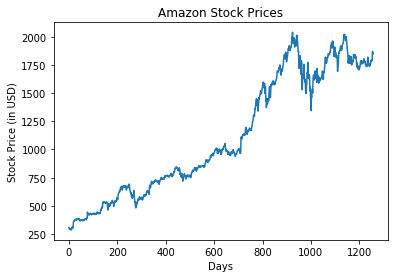

In [10]:
plt.plot(closing_price_df['Close'])
plt.xlabel("Days")
plt.ylabel("Stock Price (in USD)")
plt.title(str(name) + " Stock Prices")
plt.show()

In [11]:
# function to get average of sentiment on each day
def get_average_df(df):
  df['Sentiment'] = pd.to_numeric(df['Sentiment'],errors='coerce')
  df.dropna()
  # calculating average by mean()
  df = df.groupby(df.Date.dt.date).mean().reset_index()
  return df

In [12]:
# Run only once 
sentiment_df = get_average_df(sentiment_df)
sentiment_df.head()

,Date,Sentiment
0,2019-01-02,0.668783
1,2019-01-03,0.996000
2,2019-01-04,0.387600
3,2019-01-06,0.972500
4,2019-01-07,0.441140


In [13]:
# converting both df to same datetime format
def combine_df(df1,df2):
  df1.Date = pd.to_datetime(df1.Date)
  df2.Date = pd.to_datetime(df2.Date)
  df = pd.merge(df1, df2, on='Date')
  return df

In [14]:
df = combine_df(closing_price_df, sentiment_df)
original_df = df.copy()
df.head()

,Date,Open,Close,Difference,Sentiment
0,2019-01-02,1465.199951,1539.130005,-8.830078,0.668783
1,2019-01-03,1520.010010,1500.280029,73.930054,0.996000
2,2019-01-04,1530.000000,1575.390015,-19.729981,0.387600
3,2019-01-07,1602.310059,1629.510010,45.390015,0.441140
4,2019-01-08,1664.689941,1656.579956,27.199951,0.432075


In [15]:
scaler = MinMaxScaler()
df[['Close']] = scaler.fit_transform(df[['Close']])

diff_scaler = MinMaxScaler()
df[['Difference']] = diff_scaler.fit_transform(df[['Difference']])

scaler_sentiment = MinMaxScaler()
df[['Sentiment']] = scaler_sentiment.fit_transform(df[['Sentiment']])

df.head()

,Date,Open,Close,Difference,Sentiment
0,2019-01-02,1465.199951,0.074610,0.414088,0.716533
1,2019-01-03,1520.010010,0.000000,1.000000,0.998021
2,2019-01-04,1530.000000,0.144245,0.336921,0.474644
3,2019-01-07,1602.310059,0.248180,0.797947,0.520702
4,2019-01-08,1664.689941,0.300167,0.669168,0.512904


In [16]:
# 70-30 split
train_data, test_data = np.split(df, [int(0.7*len(df))])

In [17]:
# pd dataframe to np array for slicing and reshaping
features = ['Close', 'Sentiment', 'Difference']

train_data = train_data[features].to_numpy()
test_data =  test_data[features].to_numpy()

print('FEATURE LIST')
print([f for f in features])

FEATURE LIST
['Close', 'Sentiment', 'Difference']


In [18]:
def create_dataset(dataset, timestep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i: (i+timestep), :])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [19]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[2]))

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(172, 1, 3) (172,)
(73, 1, 3) (73,)


In [20]:
def create_model():
    model = Sequential()

    # Adding the first LSTM layer
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(1,len(features))))

    # Adding a second LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))
    
    # # Adding a third LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))

    # Adding a fourth LSTM layer
    model.add(LSTM(units = 50))

    # Adding the output layer
    model.add(Dense(units = 1)) 

    optimizers.Adam(lr=0.01)  

    return model

In [21]:
def compile_and_run(model, epochs, batch_size):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(train_x, train_y, verbose=1)
    return history, score

In [22]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()
    plt.xlabel("No. of Epochs")
    plt.ylabel("Loss")

In [23]:
LSTM_model = create_model()
print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history, score = compile_and_run(LSTM_model, epochs=100, batch_size=8) 
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/100
22/22 [==============================] - 1s 26ms/step - loss: 0.3254 - accuracy: 0.0058
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1376 - accuracy: 0.0116
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.0116
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.0058
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.0116
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.0116
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.0116
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 0.0116
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0068 - accuracy: 0.0116
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0044 - accuracy: 0.0116
Epoch 11

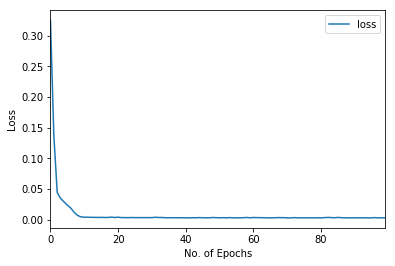

In [25]:
plot_metrics(history)

In [26]:
train_predictions = LSTM_model.predict(train_x)
test_predictions = LSTM_model.predict(test_x)

train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [27]:
test_predictions = test_predictions.flatten()
train_prices, test_prices = np.split(original_df, [int(0.7*len(original_df))])

train_prices = train_prices['Close'].to_numpy()
test_prices =  test_prices['Close'].to_numpy()
test_prices = test_prices[:-2].copy()

actual_stock_prices = np.concatenate((train_prices, test_prices))

In [28]:
test_predict_plot_1 = [None]*len(actual_stock_prices)
test_predict_plot_1[len(train_predictions)+1 : len(actual_stock_prices)-3] = test_predictions

In [29]:
df = pd.DataFrame({'Actual Values': test_prices, 'Predicted Values':test_predictions})
df.head(10)

,Actual Values,Predicted Values
0,1839.339966,1835.225220
1,1807.839966,1805.203125
2,1822.550049,1824.218872
3,1817.459961,1813.359985
4,1821.500000,1813.792114
5,1794.160034,1792.538330
6,1785.300049,1787.125977
7,1741.609985,1741.229492
8,1768.329956,1773.164307
9,1739.839966,1736.556641


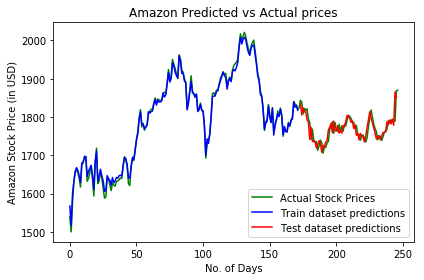

In [31]:
plt.plot(actual_stock_prices, label='Actual Stock Prices', color='green')
plt.plot(train_predictions, label='Train dataset predictions', color='blue')
plt.plot(test_predict_plot_1, label='Test dataset predictions', color='red')
plt.legend()
plt.title(str(name) + " Predicted vs Actual prices")
plt.xlabel("No. of Days")
plt.ylabel(str(name) + " Stock Price (in USD)")
plt.tight_layout()
plt.show()

Text(0,0.5,'Stock Price (in USD)')

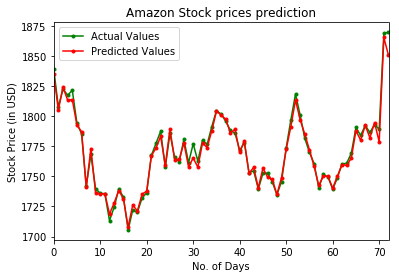

In [32]:
plot = df[['Actual Values', 'Predicted Values']].plot( marker='.', color=['green', 'red'], 
                                                title=str(name) + " Stock prices prediction on testing dataset")                                     
plot.set_xlabel("No. of Days")
plot.set_ylabel("Stock Price (in USD)")

In [33]:
def get_error_scores(y_test,y_pred):
  mse = mean_squared_error(y_test,y_pred)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  return mse, rmse, mae

In [34]:
mse, rmse, mae = get_error_scores(test_prices, test_predictions)
print('Mean Squared Error: %.3f' % mse)
print('Root Mean Squared Error: %.3f' % rmse)
print('Mean Average Error: %.3f' % mae)

Mean Squared Error: 16.876
Root Mean Squared Error: 4.108
Mean Average Error: 2.973


In [35]:
def plot_zoomed_in_graph(df):
  plot = df[['Actual Values', 'Predicted Values']].plot( marker='.',
                                                color=['green', 'red'], 
                                                title= str(name) + " Stock prices prediction")
                                                
  plot.set_xlabel("No. of Days")
  plot.set_ylabel("Stock Price (in USD)")

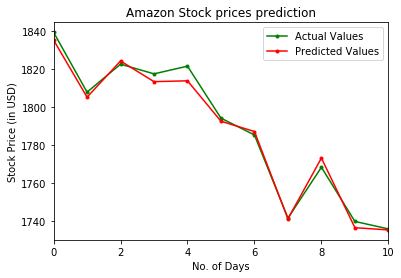

In [36]:
new_df = df.copy()
new_df = new_df.truncate(after = 10)
plot_zoomed_in_graph(new_df)

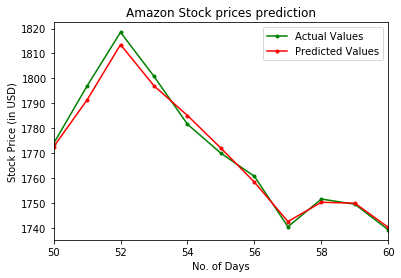

In [37]:
new_df_1 = df.copy()
new_df_1 = new_df_1.truncate(before = 50 , after = 60)
plot_zoomed_in_graph(new_df_1)

In [38]:
def add_date(df1,df2):
  df1.rename(columns = {'Actual Values':'Close'}, inplace = True)
  df = pd.merge(df1, df2, on='Close')
  df.drop(['Sentiment', 'Open', 'Difference'], axis = 1, inplace=True)
  first_column = df.pop('Date')
  df.insert(0, 'Date', first_column)
  df.rename(columns = {'Close':'Closing Price'}, inplace = True)
  return df

In [39]:
df = add_date(df, original_df)
df

,Date,Closing Price,Predicted Values
0,2019-09-13,1839.339966,1835.225220
1,2019-09-16,1807.839966,1805.203125
2,2019-09-17,1822.550049,1824.218872
3,2019-09-18,1817.459961,1813.359985
4,2019-09-19,1821.500000,1813.792114
5,2019-09-20,1794.160034,1792.538330
6,2019-09-23,1785.300049,1787.125977
7,2019-09-24,1741.609985,1741.229492
8,2019-09-25,1768.329956,1773.164307
9,2019-09-26,1739.839966,1736.556641


In [40]:
# To download results in a CSV format
# from google.colab import files

# df.to_csv('Stacked_LSTM_results.csv')
# files.download('Stacked_LSTM_results.csv')